# Semiconductor Fabrication Digital Twin (DTM/EBM)

This notebook demonstrates a probabilistic semiconductor fabrication Digital Twin modeled as a sequence of Energy-Based Models (EBMs) under the Denoising Thermodynamic Model (DTM) framework.

We:
- Map each process step (deposition, lithography, etching, annealing) to an Ising EBM.
- Sample Boltzmann distributions using a backend-agnostic sampler (auto-selects THRML if available, falls back to NumPy).
- Quantify process noise via entropy H(P) per step (denoising narrative).
- Compute probabilistic yield metrics: expected pattern fidelity and material uniformity.

Reference context: see the paper ‘An efficient probabilistic hardware architecture for diffusion-like models’ (2510.23972v1.html in this repo).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fabrication_digital_twin import (
    FabricationDigitalTwin,
    create_standard_process_flow,
)

# Display settings for plots
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['figure.dpi'] = 120


## 1) Initialize the Digital Twin
We use a small 3×3 wafer (N=9 → 2^9 states) to keep exact distributions tractable. The sampler backend is set to `auto` so it will use THRML if installed and otherwise fall back to NumPy.


In [2]:
dt = FabricationDigitalTwin(size=3, backend="auto")
backend_info = dt.sampler.get_backend_info()
backend_info


Using THRML backend (hardware-accelerated)
THRML not available, using NumPy backend (reference)


{'name': 'NumPy',
 'version': '2.3.5',
 'type': 'reference',
 'capabilities': 'Sequential Gibbs sampling (pure Python)',
 'sampling_method': 'Single-spin-flip Metropolis',
 'hardware_accelerated': 'No',
 'proven_correct': 'Yes (validated in Systems 1-7)'}

## 2) Define a target mask and process flow
We’ll use a checkerboard target mask to measure pattern fidelity. Then we load a standard 4-step process: deposition → lithography → etching → annealing.


In [3]:
# Checkerboard target in {-1, 1}
mask01 = np.indices((3, 3)).sum(axis=0) % 2
checkerboard_mask = 2 * mask01.astype(np.int8) - 1
dt.set_target_mask(checkerboard_mask)

# Add standard process steps
for step in create_standard_process_flow():
    dt.add_process_step(step)

checkerboard_mask


array([[-1,  1, -1],
       [ 1, -1,  1],
       [-1,  1, -1]], dtype=int8)

## 3) Run probabilistic yield prediction
This runs the full process without intermediate visualizations and returns per-step entropy and expected metrics, plus the final wafer state.


In [4]:
results = dt.run_yield_prediction(num_samples=5000)
results.keys(), len(results['steps'])



--- Step 1: Initial Deposition ---
Temperature: 0.50, Duration: 1.0

--- Step 2: Lithography Patterning ---
Temperature: 0.20, Duration: 0.5

--- Step 3: Etching ---
Temperature: 0.30, Duration: 0.8

--- Step 4: Final Annealing ---
Temperature: 0.10, Duration: 1.2


(dict_keys(['steps', 'final_state', 'backend']), 4)

## 4) Inspect per-step statistics
We plot the denoising trend via entropy and the expected yield metrics across steps. Lower entropy over steps indicates successful denoising; fidelity closer to 1 and uniformity near 1 are preferred.


Step  Name                         T     Entropy    Fidelity    Uniformity
--------------------------------------------------------------------------
   1  Initial Deposition        0.50     -0.0000      0.4444        1.0000
   2  Lithography Patterning    0.20      0.7083      0.4885        0.6443
   3  Etching                   0.30     -0.0000      0.5556        1.0000
   4  Final Annealing           0.10     -0.0000      0.5556        1.0000


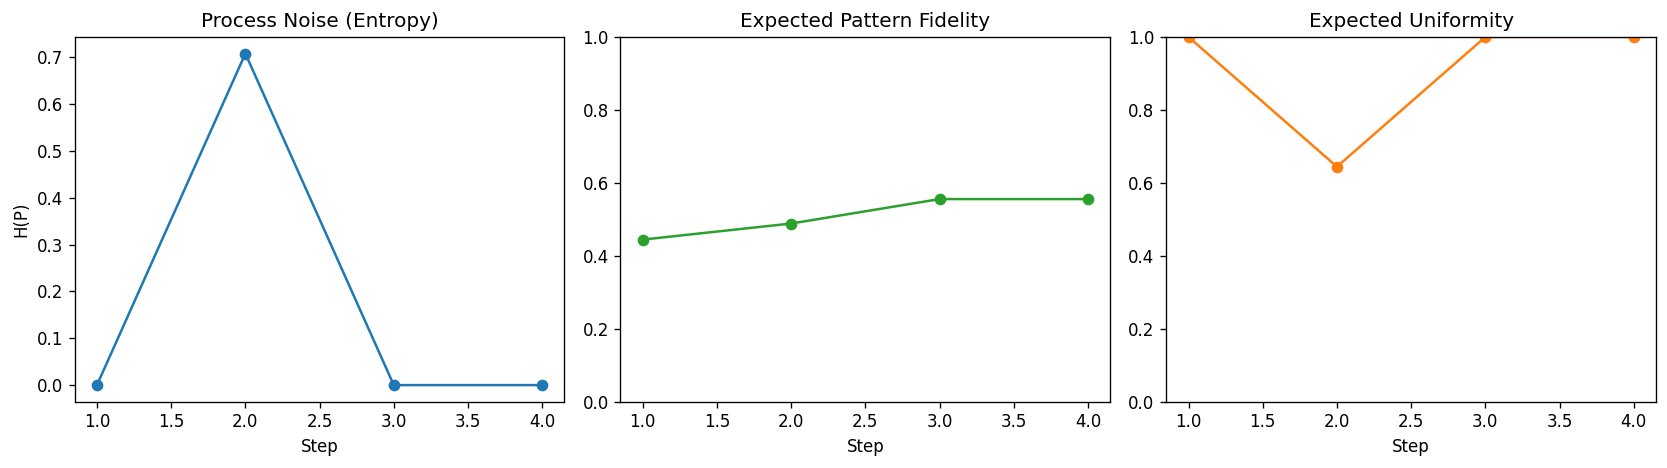

In [5]:
# Convert results to simple lists (avoid external deps)
steps = results['steps']
xs = [s['step'] for s in steps]
names = [s['name'] for s in steps]
temps = [s['temperature'] for s in steps]
entropy = [s['entropy'] for s in steps]
fidelity = [s['expected_fidelity'] for s in steps]
uniformity = [s['expected_uniformity'] for s in steps]

# Pretty-print a small table
header = f"{'Step':>4}  {'Name':<22}  {'T':>6}  {'Entropy':>10}  {'Fidelity':>10}  {'Uniformity':>12}"
print(header)
print('-' * len(header))
for s in steps:
    print(f"{s['step']:>4}  {s['name']:<22}  {s['temperature']:>6.2f}  {s['entropy']:>10.4f}  {s['expected_fidelity']:>10.4f}  {s['expected_uniformity']:>12.4f}")

# Plots
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].plot(xs, entropy, 'o-', color='#1f77b4')
axes[0].set_title('Process Noise (Entropy)')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('H(P)')

axes[1].plot(xs, fidelity, 'o-', color='#2ca02c')
axes[1].set_title('Expected Pattern Fidelity')
axes[1].set_xlabel('Step')
axes[1].set_ylim(0, 1)

axes[2].plot(xs, uniformity, 'o-', color='#ff7f0e')
axes[2].set_title('Expected Uniformity')
axes[2].set_xlabel('Step')
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()


## 5) Visualize the final wafer state
We plot the final wafer configuration after the full process. Values are in {-1, 1}: 1 corresponds to material, -1 to etched.


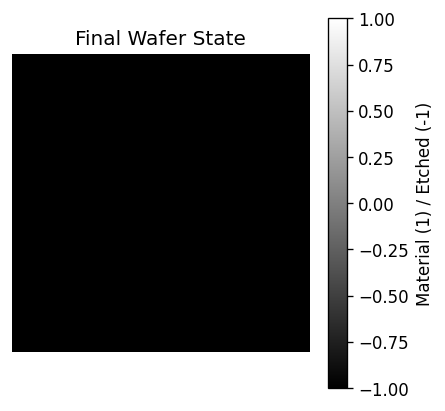

In [6]:
final_state = results['final_state']
plt.figure(figsize=(4, 4), dpi=120)
plt.imshow(final_state, cmap='gray', vmin=-1, vmax=1)
plt.colorbar(label='Material (1) / Etched (-1)')
plt.title('Final Wafer State')
plt.axis('off')
plt.show()


## 6) Methodological notes
- Each step is an Ising EBM with parameters (W, H, T).
- We sample P(s) ∝ exp(-E(s)/T) and compute: entropy H(P), expected fidelity to the target mask, and expected uniformity.
- Entropy provides a quantitative ‘denoising’ view: as the process progresses, we expect uncertainty to reduce.
- Backend auto-selection enables fast hardware sampling when THRML is installed; otherwise NumPy provides a portable reference.
